In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# NLP-specific:
import requests
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from collections import Counter

---

## Tesla Scrape #2: Using Google News
### Accessing news content for sentiment anlysis:

In [2]:
def scrape_google_news_articles(url):
    req = requests.get(url)
    soup = BeautifulSoup(req.content, 'html.parser')

    article_titles = soup.body.find_all('h4', {'class': ['gPFEn', 'JtKRv']})
    
    headlines = []
    date_article_titles = []
    time_article_titles = []

    for article in article_titles:
        headline = article.text
        date_time_element = article.find_previous('time', 'hvbAAd')
        if date_time_element:
            date_time_string = date_time_element['datetime']
            date_string, time_string = date_time_string.split("T")
            date_obj = datetime.strptime(date_string, "%Y-%m-%d")
            time_obj = datetime.strptime(time_string.split("Z")[0], "%H:%M:%S")
            headlines.append(headline)
            date_article_titles.append(date_obj)
            time_article_titles.append(time_obj)

    df = pd.DataFrame({'headline': headlines, 'date': date_article_titles, 'time': time_article_titles})
    return df

In [3]:
url = 'https://news.google.com/topics/CAAqIggKIhxDQkFTRHdvSkwyMHZNR1J5T1RCa0VnSmxiaWdBUAE?hl=en-US&gl=US&ceid=US%3Aen'
df = scrape_google_news_articles(url)
df.head()

,headline,date,time
0,Tesla’s China EV sales fall 11%,2023-10-09,1900-01-01 14:14:00
1,Tesla's China-made EV sales volume falls 10.9%...,2023-10-09,1900-01-01 14:51:34
2,Tesla Stock Drops as China Deliveries Dive. Oc...,2023-10-10,1900-01-01 03:40:00
3,Volvo is Accelerating Towards a 100% BEV Lineu...,2023-10-09,1900-01-01 13:36:00
4,Tesla Model 3 And Model Y Cost Less Than The A...,2023-10-10,1900-01-01 14:30:32


---

## Sentiment Analysis

In [4]:
# NLTK VADER for sentiment analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Updating VADER lexicon with domain-specific words and corresponding (discretionary) values:
new_words = {
    'eco-friendly': 10,
    'clean': 5,
    'sustainable': 5,
    'environment': 10,
    'green': 5, # regarded as neutral scoring in baseline VADER 
    'renewable': 15,
    'degradation': -10,
    'infrastructure': -5,
    'costly': -10
}

# Instantiate the sentiment intensity analyzer with the existing lexicon
vader = SentimentIntensityAnalyzer()

# Update the lexicon
# vader.lexicon.update(new_words)

In [5]:
# Iterate through TSLA's headlines to calcualate the polarity scores
scores = [vader.polarity_scores(head) for head in df.headline]

# Convert the list of dicts into a DataFrame
df_scores = pd.DataFrame(scores)

# Join the DataFrames
df = df.join(df_scores)

In [6]:
# Saving df to .csv
df.to_csv('../data/df_sentiment_analysis.csv', index=True)

In [7]:
df.head()

,headline,date,time,neg,neu,pos,compound
0,Tesla’s China EV sales fall 11%,2023-10-09,1900-01-01 14:14:00,0.000,1.000,0.0,0.000
1,Tesla's China-made EV sales volume falls 10.9%...,2023-10-09,1900-01-01 14:51:34,0.000,1.000,0.0,0.000
2,Tesla Stock Drops as China Deliveries Dive. Oc...,2023-10-10,1900-01-01 03:40:00,0.000,1.000,0.0,0.000
3,Volvo is Accelerating Towards a 100% BEV Lineu...,2023-10-09,1900-01-01 13:36:00,0.000,1.000,0.0,0.000
4,Tesla Model 3 And Model Y Cost Less Than The A...,2023-10-10,1900-01-01 14:30:32,0.145,0.855,0.0,-0.296


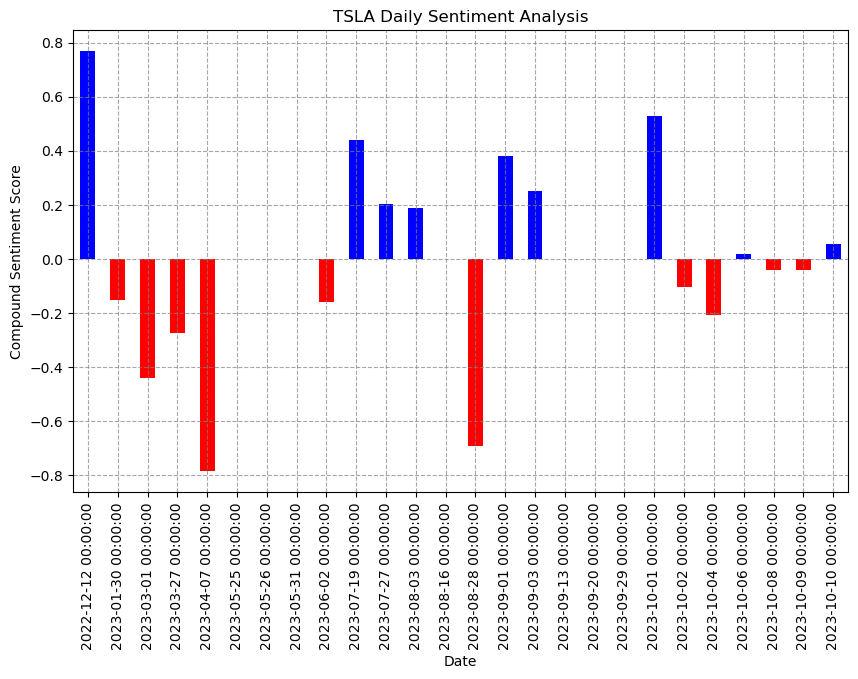

In [8]:
# Set the style
plt.style.use("seaborn-v0_8-bright")

# Group by date from the dataframe and calculate the mean
mean_c = df.groupby(['date']).mean(numeric_only=True)

# Get the cross-section of compound in the 'columns' axis
mean_c = mean_c.xs('compound', axis='columns')

# Create a bar chart with custom bar colors
plt.figure(figsize=(10, 6))
colors = ['blue' if score >= 0 else 'red' for score in mean_c]
mean_c.plot(kind='bar', color=colors)

# Add axis labels and a title
plt.xlabel('Date')
plt.ylabel('Compound Sentiment Score')
plt.title('TSLA Daily Sentiment Analysis')

# Add a gray background and gridlines
plt.grid(color='gray', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

**Analysis:** High or low compound sentiment scores for TSLA on specific days are influenced by various factors. A relatively large negative score, such as the score on 2023-08-31, may be due to adverse news like regulatory concerns or negatively-received actions by leadership. Conversely, a relatively large positive score, such as the score on 2023-09-28, may result from favorable news such as strong sales figures or positive market sentiment overall. Market events, company performance, and external factors significantly impact TSLA's daily sentiment scores.

In [9]:
# Function to get the single day DataFrame

def get_single_day_df(df, date):
    # Filter the DataFrame to select rows for the specified date
    single_day_df = df[df['date'] == date].copy()

    # Extract the time component from the datetime and set it as the index
    single_day_df['time'] = pd.to_datetime(single_day_df['time']).dt.time
    single_day_df.set_index('time', inplace=True)

    # Keep only the desired columns
    single_day_df = single_day_df[['headline', 'date', 'neg', 'neu', 'pos', 'compound']]

    return single_day_df

In [10]:
df_2023_10_09 = get_single_day_df(df, '2023-10-09')
df_2023_10_09

,headline,date,neg,neu,pos,compound
time,,,,,,
14:14:00,Tesla’s China EV sales fall 11%,2023-10-09,0.000,1.000,0.000,0.0000
14:51:34,Tesla's China-made EV sales volume falls 10.9%...,2023-10-09,0.000,1.000,0.000,0.0000
13:36:00,Volvo is Accelerating Towards a 100% BEV Lineu...,2023-10-09,0.000,1.000,0.000,0.0000
18:49:00,Tesla cuts EV prices again following productio...,2023-10-09,0.196,0.804,0.000,-0.2960
17:23:53,Tesla base models are now cheaper than the ave...,2023-10-09,0.000,1.000,0.000,0.0000
16:23:00,Tesla owners are using the new button on the s...,2023-10-09,0.000,1.000,0.000,0.0000
17:47:38,Early Tesla Cybertruck goes for $400000 at auc...,2023-10-09,0.000,1.000,0.000,0.0000
09:53:00,"Would You Pay $400,000 For a Tesla Cybertruck?...",2023-10-09,0.135,0.865,0.000,-0.1027
21:40:14,Tesla Cybertruck early build auctioned for $40...,2023-10-09,0.000,1.000,0.000,0.0000


In [11]:
# Function to visualize sentiment scores for a single day
def visualize_sentiment_scores(single_day_df):
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(10, 6))

    # Define the colors for 'neg', 'neu', and 'pos'
    colors = ['red', 'orange', 'green']

    # Plot the stacked bar chart
    single_day_df[['neg', 'neu', 'pos']].plot(kind='bar', stacked=True, ax=ax, color=colors)

    # Set the title, labels, and legend
    ax.set_title(f"TSLA Aggregate Sentiment Score on {single_day_df['date'].iloc[0]}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Sentiment Scores")
    ax.set_ylim(0, 1)  # Set the y-axis limits from 0 to 1
    ax.legend(["Negative", "Neutral", "Positive"])

    # Show the plot
    plt.show()

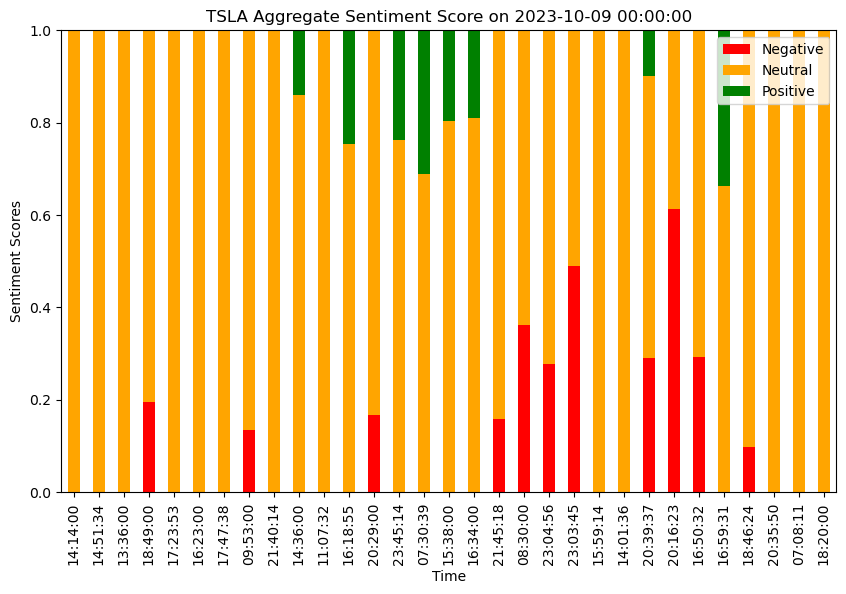

In [12]:
visualize_sentiment_scores(df_2023_10_09)

In [13]:
df_2023_10_06 = get_single_day_df(df, '2023-10-06')
df_2023_10_06

,headline,date,neg,neu,pos,compound
time,,,,,,
10:01:43,Tesla owners are loving the new button on iPho...,2023-10-06,0.000,0.719,0.281,0.5994
16:43:00,Giant Tesla Megapack project turns on to stabi...,2023-10-06,0.000,1.000,0.000,0.0000
21:44:00,Tesla Stock Receives Price Target Cuts As Wall...,2023-10-06,0.273,0.727,0.000,-0.5423


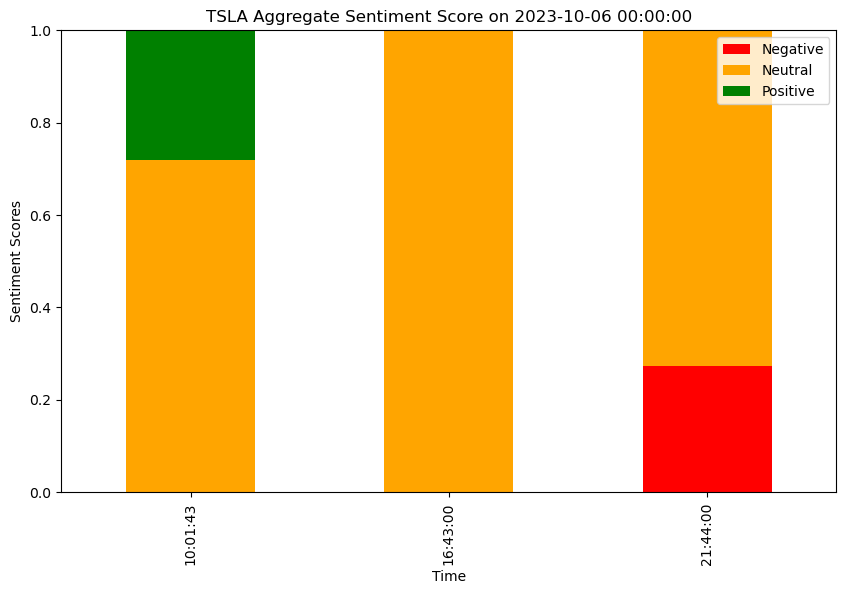

In [14]:
visualize_sentiment_scores(df_2023_10_06)

---

## Exploring the Most Common Headline Words

News headlines impact financial markets and affect the closing price of Tesla's stock (and all equities at large). This top ten list shows the most common words in the headlines of Tesla's news cycle, per Google News' amalagamtor. Less stop words and the company's proper name, the most common word is 'model,' most likely referring to the Tesla Model S, X, 3, and Y. This indicates that most news is centered around the announcement or releases of Tesla's next generation model cars. This indicator was used in the SARIMAX model, where an exogenous variable was created to indicate the 2-week interval (discretionary length) succeeding new product announcements and model distributions. There was only one interval during the 2021-2023 time period, which corresponded to the announcement of the Tesla Model 3 design refresh on Sept 1, 2023

In [15]:
# Define a list of stop words
stop_words = set(stopwords.words('english'))

# Tokenize and preprocess the text in the 'headline' column
word_counts = Counter()

for headline in df['headline']:
    tokens = nltk.word_tokenize(headline.lower())  # Tokenize and convert to lowercase
    cleaned_tokens = [token for token in tokens if token.isalnum() and token not in stop_words]
    word_counts.update(cleaned_tokens)

# Get the top 10 most used words
top_words = word_counts.most_common(10)

# Display the top 10 words and their frequencies
for word, frequency in top_words:
    print(f'{word}: {frequency}')

tesla: 99
ev: 11
model: 11
stock: 10
new: 10
cybertruck: 9
china: 7
car: 6
union: 6
musk: 6
